### import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from shapeGMMTorch import scripts
import MDAnalysis as md
import torch
import pickle
from shapeGMMTorch import similarities 
from shapeGMMTorch import plots

### load trajectory

In [4]:
#data_path = "/scratch/projects/hockygroup/ss12902/opes_metad_folded_unfolded_ld1_360K/analysis/"

# moved to hockygroup-archive
data_path = "/scratch/projects/hockygroup-archive/PublishedPapers/2023-Sasmal-posLDA-JCTC/HP35/opes_metad_sims/main_sim/analysis/"
backbone_selection_101 = "(name C and resid 1) or (name C CA N and not resid 1 35) or (name N and resid 35)"
prmtopFileName =  data_path + "npt.gro"
trajFile = data_path+"opes_metad_ld1_hp35_360K_bf_8.0_barrier_10.0_wrapped.xtc"

coord = md.Universe(prmtopFileName,trajFile)
sel_backbone_101 = coord.select_atoms(backbone_selection_101)
print("Number of atoms in trajectory:", coord.atoms.n_atoms)
print("Number of frames in trajectory:",coord.trajectory.n_frames)
print("Number of atoms being analyzed:",sel_backbone_101.n_atoms)
print("Number of frames being analyzed:",coord.trajectory.n_frames)
traj_backbone_101 = np.empty((coord.trajectory.n_frames,sel_backbone_101.n_atoms,3),dtype=float)
count = 0
for ts in coord.trajectory:
    traj_backbone_101[count,:,:] = sel_backbone_101.positions - sel_backbone_101.center_of_geometry()
    count += 1

Number of atoms in trajectory: 60392
Number of frames in trajectory: 50001
Number of atoms being analyzed: 101
Number of frames being analyzed: 50001


In [5]:
print(sel_backbone_101.atoms.indices)

[ 19  21  23  30  32  34  42  44  46  57  59  61  69  71  73  89  91  93
 111 113 115 121 123 125 137 139 141 157 159 161 164 166 168 181 183 185
 195 197 199 219 221 223 230 232 234 240 242 244 260 262 264 270 272 274
 284 286 288 303 305 315 317 319 321 336 338 340 360 362 364 379 381 383
 396 398 400 413 415 417 431 433 435 450 452 454 469 471 473 491 493 495
 506 508 510 528 530 532 535 537 539 554 556]


### load OPES bisas from COLVAR

(50001,)
(50001,)


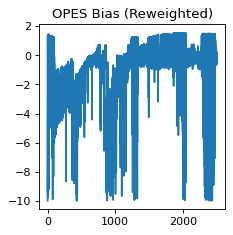

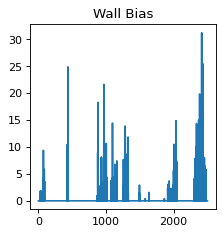

In [6]:
time, ld1, opes_bias = np.loadtxt(data_path+"../COLVAR", usecols=(0,1,2), unpack=True)
time *= 1e-3 # in ns 

wall_bias = np.sum(np.loadtxt(data_path+"../COLVAR", usecols=(-2,-1)), axis=1)[::50]
print(wall_bias.shape)

opes_bias = opes_bias[::50]
time = time[::50]
ld1 = ld1[::50]
print(opes_bias.shape)

plt.figure(figsize=(3,3), dpi=80)
plt.title("OPES Bias (Reweighted)")
plt.plot(time, opes_bias)

plt.figure(figsize=(3,3), dpi=80)
plt.title("Wall Bias")
plt.plot(time, wall_bias)

### get the weights

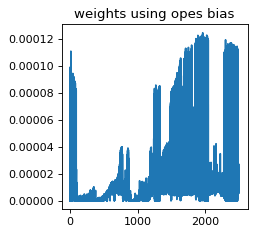

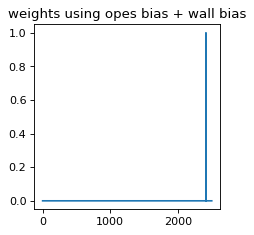

In [7]:
#When the temperature is 360.000000 kelvin kT is equal to 0.715393 kcal/mol
kt = 0.715393
weights = np.exp(opes_bias/kt)
weights /= np.sum(weights)

plt.figure(figsize=(3,3), dpi=80)
plt.title("weights using opes bias")
plt.plot(time, weights)

weights = np.exp((opes_bias+wall_bias)/kt)
weights /= np.sum(weights)

plt.figure(figsize=(3,3), dpi=80)
plt.title("weights using opes bias + wall bias")
plt.plot(time, weights)

### Use only the frames with zero wall bias.

1. Okay, so we are not going to use the frames with non-zero wall bias. 

2. Because that makes the weight distribution totally worse. 

3. Let's use only the frames with zero wall bias.

48937


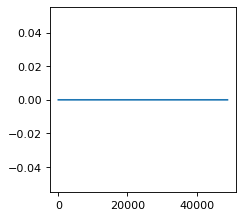

In [8]:
zero_wall_bias_indx = [x[0] for x in np.argwhere(wall_bias == 0.0)]
print(len(zero_wall_bias_indx))

plt.figure(figsize=(3,3), dpi=80)
plt.plot(wall_bias[zero_wall_bias_indx])

(48937, 101, 3)
(48937,)


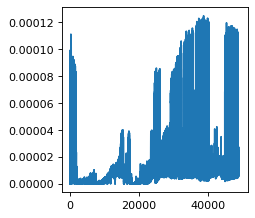

In [9]:
traj = traj_backbone_101[zero_wall_bias_indx]
print(traj.shape)

kt = 0.715393
wgts = np.exp(opes_bias/kt)[zero_wall_bias_indx]
wgts /= np.sum(wgts)
print(wgts.shape)

plt.figure(figsize=(3,3), dpi=80)
plt.plot(wgts)

### perform cluster scan 

In [10]:
# define cluster array
cluster_array = np.arange(2,8,1).astype(int)
print(cluster_array)

[2 3 4 5 6 7]


In [29]:
# perform cluster scan on this data (use ~ 90% data for training)
#train, cv = scripts.cross_validate_cluster_scan(traj, 44000, frame_weights = wgts, covar_type="kronecker", cluster_array = cluster_array, n_training_sets=4, n_attempts = 10, dtype=torch.float64, device=torch.device("cuda:0"))

# write to data files
#np.savetxt("train.dat", np.column_stack((cluster_array, train)))
#np.savetxt("cv.dat", np.column_stack((cluster_array, cv)))

Number of frames to train each model: 44000
Number of frames to predict each model: 4937
Number of training sets: 4
Number of clusters: 6
Number of attempts per set/cluster: 10
   Training Set      N Clusters         Attempt  Log Like per Frame    CPU Time (s)
------------------------------------------------------------------------------------
              1               2               1             419.707           6.448
              1               2               2             419.708           6.250
              1               2               3             418.968           7.333
              1               2               4             419.707           6.316
              1               2               5             419.561           6.935
              1               2               6             419.708           6.041
              1               2               7             419.710           6.249
              1               2               8             419.55

              2               5               5             438.262          18.259
              2               5               6             438.588          13.667
              2               5               7             438.614          15.427
              2               5               8             438.266          16.087
              2               5               9             442.046          17.745
              2               5              10             442.917          20.561
              2               6               1             447.009          19.228
              2               6               2             439.477          18.324
              2               6               3             447.385          17.225
              2               6               4             442.621          14.781
              2               6               5             444.568          18.441
              2               6               6             444.021         

              4               3               3             433.340           6.794
              4               3               4             433.351           6.982
              4               3               5             433.273           7.513
              4               3               6             433.272           8.123
              4               3               7             433.579           6.481
              4               3               8             427.590          11.538
              4               3               9             433.337           6.706
              4               3              10             433.187           7.643
              4               4               1             436.777          14.087
              4               4               2             436.788          11.051
              4               4               3             440.210          14.880
              4               4               4             440.210         

In [11]:
train = np.loadtxt("train.dat")[:,1:]
cv = np.loadtxt("cv.dat")[:,1:]

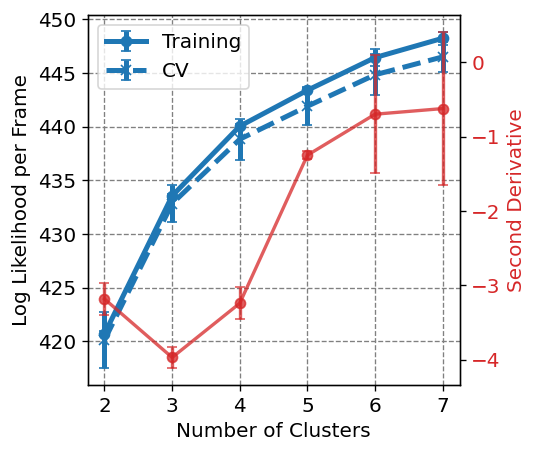

In [12]:
# shapeGMMTorch plots has a built-in plot function for this type of plot
fig, ax = plt.subplots(1,1,figsize=(4,4), dpi= 120, facecolor='w', edgecolor='k')
plots.plot_log_likelihood_with_dd(ax,cluster_array, train, cv, fontsize=12, ylabel1=True, ylabel2=True, xlabel=True)

### 3 clusters

In [32]:
#wsgmm = scripts.sgmm_fit_with_attempts(traj, 3, 20, wgts, device=torch.device("cuda:0"), dtype=torch.float64)

#with open("wsgmm_3states.pickle", "wb") as f_o:
#    pickle.dump(wsgmm, f_o)

Number of training frames: 48937
Number of clusters: 3
Number of attempts: 20
 Attempt  Log Like per Frame    CPU Time (s)
--------------------------------------------------
       1             433.526           9.235
       2             433.199           9.865
       3             433.524          11.108
       4             433.237          12.259
       5             433.215          10.492
       6             433.210           8.735
       7             433.500           8.607
       8             433.525           9.791
       9             433.536           7.262
      10             433.267           6.563
      11             433.264           9.365
      12             433.208          11.545
      13             433.248          11.057
      14             433.301           8.499
      15             433.197           8.309
      16             433.283           9.358
      17             433.523          11.018
      18             433.519           8.162
      19        

### 4 clusters 

In [33]:
#wsgmm = scripts.sgmm_fit_with_attempts(traj, 4, 20, wgts, device=torch.device("cuda:0"), dtype=torch.float64)

#with open("wsgmm_4states.pickle", "wb") as f_o:
#    pickle.dump(wsgmm, f_o)

Number of training frames: 48937
Number of clusters: 4
Number of attempts: 20
 Attempt  Log Like per Frame    CPU Time (s)
--------------------------------------------------
       1             435.980           8.367
       2             440.025          13.108
       3             435.895          12.817
       4             440.025          11.135
       5             436.732          17.272
       6             436.089           9.603
       7             436.051          11.391
       8             435.691          11.734
       9             440.094          15.871
      10             436.012          10.671
      11             439.784          11.234
      12             436.789          15.135
      13             435.547          14.172
      14             436.131           9.226
      15             436.995          17.692
      16             435.440           9.967
      17             439.773          11.110
      18             435.177          13.984
      19        

### load shapeGM objects 

In [2]:
wsgmm_list = []
for i in [3,4]:
    with open("wsgmm_%dstates.pickle"%i, "rb") as fo:
        wsgmm = pickle.load(fo)
    wsgmm_list.append(wsgmm)

In [3]:
print(wsgmm_list[0].weights)
print(wsgmm_list[0].cluster_ids.shape)

print(wsgmm_list[1].weights)
print(wsgmm_list[1].cluster_ids.shape)

[0.72007088 0.17669015 0.10323897]
(48937,)
[0.38732851 0.33597865 0.17948318 0.09720966]
(48937,)


### Check the bhattacharya distances for cluster centers w.r.t. initial clusters

### load the reference GMM object

In [4]:
#path_to_ref_gmm = "/scratch/projects/hockygroup/ss12902/hp35_sGMM/"

# moved to hockygroup-archive
path_to_ref_gmm = "/scratch/projects/hockygroup-archive/PublishedPapers/2023-Sasmal-posLDA-JCTC/HP35/hp35_sGMM_and_lda_coords/"

with open(path_to_ref_gmm+"hp35_wsgmm_6_clusters_reorderd.pickle", "rb") as f_o:
    wsgmm_ref = pickle.load(f_o)

### Calculate the Bhattacharya distances

In [5]:
dist_data = []

# loop over objects [3,4]
for i in range(len(wsgmm_list)):
    
    vals = []
    # loop over number of clusters
    for j in range(wsgmm_list[i].n_clusters):
        
        # wrt 0 (i.e. folded cluster)
        dij_0 = similarities.bhattacharyya_distance(wsgmm_list[i], j, wsgmm_ref, 0)
        
        # wrt 4 (i.e. unfolded cluster)
        dij_4 = similarities.bhattacharyya_distance(wsgmm_list[i], j, wsgmm_ref, 4)
        
        vals.append([dij_0, dij_4])
        
    #dist_data.append(np.array(vals))
    dist_data.append(np.log(np.array(vals)))     # take log y

In [6]:
print(dist_data)

[array([[0.96144711, 3.96314494],
       [2.63882979, 3.6252176 ],
       [3.59226011, 2.67873537]]), array([[2.00652981, 3.95697816],
       [0.33723621, 4.04976353],
       [2.68531449, 3.59137798],
       [3.61722703, 2.7183132 ]])]


In [7]:
# save the data
np.savetxt('logb-dist.txt', dist_data[0])

### Plot the distances for 3 cluster case

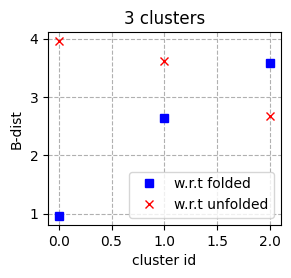

In [19]:
plt.figure(figsize=(3,2.5))
plt.xlabel("cluster id")
plt.ylabel("B-dist")
plt.grid(linestyle="--")
plt.title("3 clusters")
wsgmm3 = wsgmm_list[0]
for i in range(wsgmm3.n_clusters):
    x = plt.plot(i, dist_data[0][i,0], 's', color="b", label="w.r.t folded" if i == 0 else "")
    y = plt.plot(i, dist_data[0][i,1], 'x', color="r", label="w.r.t unfolded" if i == 0 else "")
plt.legend()

### Plot the distances for 4 cluster case 

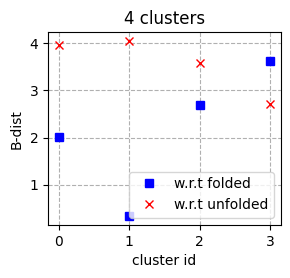

In [20]:
plt.figure(figsize=(3,2.5))
plt.xlabel("cluster id")
plt.ylabel("B-dist")
plt.grid(linestyle="--")
plt.title("4 clusters")
wsgmm4 = wsgmm_list[1]
for i in range(wsgmm4.n_clusters):
    x = plt.plot(i, dist_data[1][i,0], 's', color="b", label="w.r.t folded" if i == 0 else "")
    y = plt.plot(i, dist_data[1][i,1], 'x', color="r", label="w.r.t unfolded" if i == 0 else "")
plt.legend()

### We are going to choose 3 state shapeGMM fit object to get the new LD1 between

c=0 (closest to the folded) and c=2 (closest to unfolded)

In [21]:
print(wsgmm3.cluster_ids.shape)

(48937,)


In [22]:
c0_indx = [x[0] for x in np.argwhere(wsgmm3.cluster_ids == 0)] 
c2_indx = [x[0] for x in np.argwhere(wsgmm3.cluster_ids == 2)]

print(len(c0_indx), len(c2_indx))

13751 19826


### Global Alignment of trajectory 

In [23]:
# load traj 
global_aligned_traj = np.load("global_aligned_traj.npy", allow_pickle=True)
print(global_aligned_traj.shape)

(48937, 101, 3)


In [24]:
c0_traj = global_aligned_traj[c0_indx,:,:]   # close to folded (set labels 1)
c2_traj = global_aligned_traj[c2_indx,:,:]   # close to unfolded (set labels 0)

comb_traj = np.concatenate([c0_traj, c2_traj], axis=0)
labels = np.concatenate([np.ones(len(c0_indx)), np.zeros(len(c2_indx))], axis=0)

print(comb_traj.shape, labels.shape)

(33577, 101, 3) (33577,)


### perform weighted LDA calculation

In [25]:
print(global_aligned_traj.shape, wgts.shape, wsgmm3.cluster_ids.shape)

(48937, 101, 3) (48937,) (48937,)


In [26]:
from WeightedLDA import WeightedLDA as WL

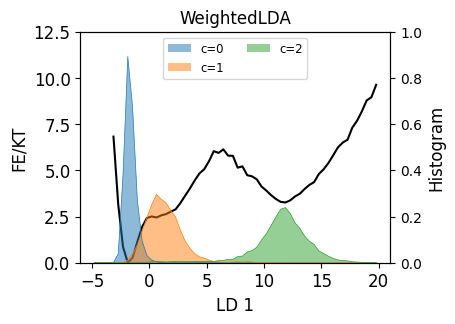

In [27]:
ld_range = (-5,20)
nbins = 60

fig, ax = plt.subplots(1, 1, figsize=(4,3)) 

ax.set_title("WeightedLDA", fontsize=12)
#ax.set_ylabel("FE (kcal/mol)",fontsize=12)
ax.set_ylabel("FE/KT", fontsize=12)
ax.set_xlabel("LD 1", fontsize=12)
ax.tick_params(axis='both',labelsize=12)

# lda calculation
lda = WL.WeightedLDA()

# get the weights
sel_weights = np.concatenate([wgts[c0_indx], wgts[c2_indx]], axis=0)

lda.fit(comb_traj.reshape(comb_traj.shape[0], comb_traj.shape[1]*3), labels, wgts=sel_weights)
ld1_all = lda.transform(global_aligned_traj.reshape(global_aligned_traj.shape[0], global_aligned_traj.shape[1]*3))[:,0]

# histogramming the lda and calculate free energy
hist, bins = np.histogram(ld1_all, range=ld_range, bins=nbins, density=True, weights=wgts)
#fe = -kt*np.log(hist)
fe = -np.log(hist)
grids = (bins[:-1] + bins[1:])/2
ax.plot(grids, fe-fe.min(), lw=1.5, color="k", ls="-")
ax.set_ylim(0,12.5)

ax_inv = ax.twinx()
ax_inv.set_ylim(0,1.0)
ax_inv.set_ylabel("Histogram", fontsize=12)
for i in range(wsgmm3.n_clusters):
    indices = [x[0] for x in np.argwhere(wsgmm3.cluster_ids == i)]
    H, _ = np.histogram(ld1_all[indices], range=ld_range, bins=nbins, density=True, weights=wgts[indices])

    ax_inv.fill_between(grids, H, alpha=0.5, label="c=%d"%i)
    ax_inv.plot(grids, H, lw=0.5)
    
ax_inv.legend(ncol=2, loc="upper center", fontsize="small")

In [28]:
print(kt)
print(max(ld1_all), min(ld1_all))

0.715393
25.99602279609659 -3.1237170964050227


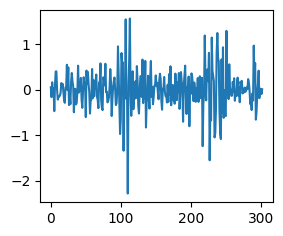

In [29]:
plt.figure(figsize=(3,2.5))
#plt.grid()
plt.plot(lda.scalings_[:,0], '-')

In [29]:
# calculating the standard deviation

print(np.std(ld1_all[[x[0] for x in np.argwhere(wsgmm3.cluster_ids == 0)]])/3)

0.17516733556047437


In [30]:
print(ld1_all.shape)

(48937,)


### stuff below from this point is very recent (Feb 22, 2025)

Let's try multistate LDA coordinate instead of focusing on just folded and unfolded states. $\newline$Here we are choosing 3 state shapeGMM fit as evident from elbow plot. $\newline$ We will use the one with largest eiegen value.

In [34]:
print(wgts.shape, global_aligned_traj.shape, wsgmm3.cluster_ids.shape)

(48937,) (48937, 101, 3) (48937,)


$\textbf{LDA Calculation}$

In [77]:
lda = WL.WeightedLDA()
lda.fit(global_aligned_traj.reshape(global_aligned_traj.shape[0], global_aligned_traj.shape[1]*3), wsgmm3.cluster_ids, wgts)
all_lds = lda.transform(global_aligned_traj.reshape(global_aligned_traj.shape[0], global_aligned_traj.shape[1]*3))

In [79]:
# save the first component only -->
np.savetxt('ld1_coeff_multi_3states.txt', lda.scalings_[:,0])

In [78]:
print(lda.scalings_.shape)

(303, 2)


$\textbf{LD 1: First component from LDA.}$

-2.9725149458089652 25.1749609286268


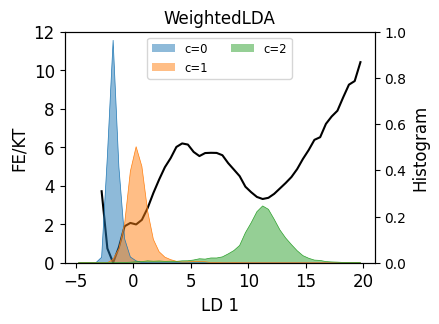

In [74]:
ld1 = all_lds[:,0]

ld_range = (-5,20)
nbins = 50

fig, ax = plt.subplots(1, 1, figsize=(4,3)) 

ax.set_title("WeightedLDA", fontsize=12)
#ax.set_ylabel("FE (kcal/mol)",fontsize=12)
ax.set_ylabel("FE/KT", fontsize=12)
ax.set_xlabel("LD 1", fontsize=12)
ax.tick_params(axis='both',labelsize=12)


# histogramming the lda and calculate free energy
hist, bins = np.histogram(ld1, range=ld_range, bins=nbins, density=True, weights=wgts)
#fe = -kt*np.log(hist)
fe = -np.log(hist)
grids = (bins[:-1] + bins[1:])/2
ax.plot(grids, fe-fe.min(), lw=1.5, color="k", ls="-")
ax.set_ylim(0,12)

ax_inv = ax.twinx()
ax_inv.set_ylim(0,1.0)
ax_inv.set_ylabel("Histogram", fontsize=12)
for i in range(wsgmm3.n_clusters):
    indices = [x[0] for x in np.argwhere(wsgmm3.cluster_ids == i)]
    H, _ = np.histogram(ld1[indices], range=ld_range, bins=nbins, density=True, weights=wgts[indices])

    ax_inv.fill_between(grids, H, alpha=0.5, label="c=%d"%i)
    ax_inv.plot(grids, H, lw=0.5)
    
ax_inv.legend(ncol=2, loc="upper center", fontsize="small")
print(min(ld1), max(ld1))

$\textbf{LD 2: Second component from LDA}$

-9.791089788790556 9.778026942976329


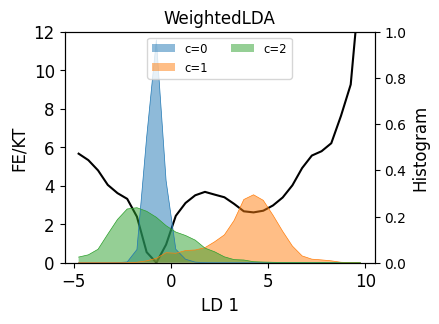

In [76]:
ld1 = all_lds[:,1]

ld_range = (-5,10)
nbins = 30

fig, ax = plt.subplots(1, 1, figsize=(4,3)) 

ax.set_title("WeightedLDA", fontsize=12)
#ax.set_ylabel("FE (kcal/mol)",fontsize=12)
ax.set_ylabel("FE/KT", fontsize=12)
ax.set_xlabel("LD 1", fontsize=12)
ax.tick_params(axis='both',labelsize=12)


# histogramming the lda and calculate free energy
hist, bins = np.histogram(ld1, range=ld_range, bins=nbins, density=True, weights=wgts)
#fe = -kt*np.log(hist)
fe = -np.log(hist)
grids = (bins[:-1] + bins[1:])/2
ax.plot(grids, fe-fe.min(), lw=1.5, color="k", ls="-")
ax.set_ylim(0,12)

ax_inv = ax.twinx()
ax_inv.set_ylim(0,1.0)
ax_inv.set_ylabel("Histogram", fontsize=12)
for i in range(wsgmm3.n_clusters):
    indices = [x[0] for x in np.argwhere(wsgmm3.cluster_ids == i)]
    H, _ = np.histogram(ld1[indices], range=ld_range, bins=nbins, density=True, weights=wgts[indices])

    ax_inv.fill_between(grids, H, alpha=0.5, label="c=%d"%i)
    ax_inv.plot(grids, H, lw=0.5)
    
ax_inv.legend(ncol=2, loc="upper center", fontsize="small")
print(min(ld1), max(ld1))

$\textbf{Plot coefficients, from LD components.}$

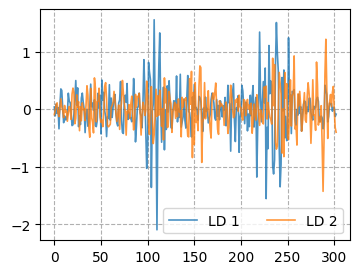

In [87]:
plt.figure(figsize=(4,3))
plt.grid(linestyle='--')
plt.plot(lda.scalings_[:,0], label='LD 1', lw=1.2, alpha=0.8)
plt.plot(lda.scalings_[:,1], label='LD 2', lw=1.2, alpha=0.8)
plt.legend(ncol=2)